# Enron POI Detector
## Background
Enron was a big scandal in Wallstreet that embodied greed, pride and fraud in Corporate America. Originally an energy company in Natural Gas, it became big when it started to trade energy in the stock exchange. They used this thing called "Mark-to-Market" pitch that basically allows them to sell their stock by reporting future earnings. Imagine if someone approached you and told you to invest in their company that will make 100 million USD even if their powerplant was not yet built. Naturally, everyone bought it and their prices went up. Long story short, the businesses went bankrupt after reporting huge losses and their investors lost their money. People responsible were called into question to answer for the fraud that they have commited.

## 1.1. Summary of Dataset
The dataset contains 146 People with 21 Features. The features are split according to Email and Financials of these people. There are 18 People marked as Person of Interest, which includes CEO Jeffrey Skillings, Chairman Kenneth Lay and CFO Andrew Fastow. The objective of this analysis is create an algorithm that will be able to identify Person of Interests or POI by using their emails and financials.

Count of People:  146
Count of Features:  21
Count of POI:  18


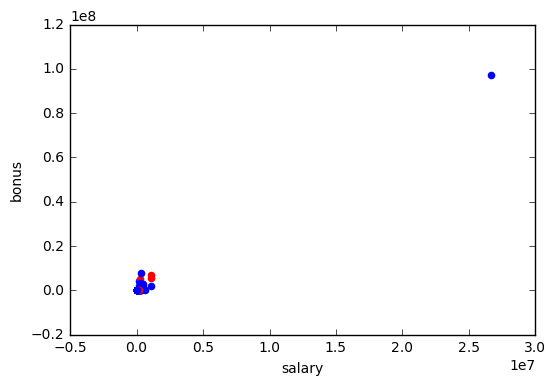

In [135]:
import sys
import pickle
import matplotlib.pyplot
import pprint
import pandas as pd
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.

features_list = [ "poi",
    'salary', 'bonus', 'director_fees', 'other', 'long_term_incentive',
    'deferral_payments', 'total_payments', 'loan_advances', 'deferred_income', 
    'expenses',
    
    'exercised_stock_options', 'restricted_stock', 
    'restricted_stock_deferred', 'total_stock_value',
    
    'to_messages', 'from_poi_to_this_person',
    'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)

### Counts to describe the dataset
print "Count of People: ", len(my_dataset.keys())
print "Count of Features: ", len(my_dataset["METTS MARK"].keys())
print "Count of POI: ", len(dict([(k,r) for k,r in my_dataset.iteritems() if r['poi'] == 1]))

### Scatterplot function that marks the person of interest in red.
def plotScatter(dat, labels=features_list):
    for point in dat:
        poi = point[0]
        if poi == 0:
            matplotlib.pyplot.scatter( point[1], point[2], color = "blue" )
        else:
            matplotlib.pyplot.scatter( point[1], point[2], color = "red" )
    matplotlib.pyplot.xlabel(labels[1])
    matplotlib.pyplot.ylabel(labels[2])
    matplotlib.pyplot.show()
    
plotScatter(data)

## 1.2. Outliers
We plot the data according to their bonus and salary and notice an outlier, which is the Total. We simply remove this outlier and see a more normal scatterplot with POI marked in Red.

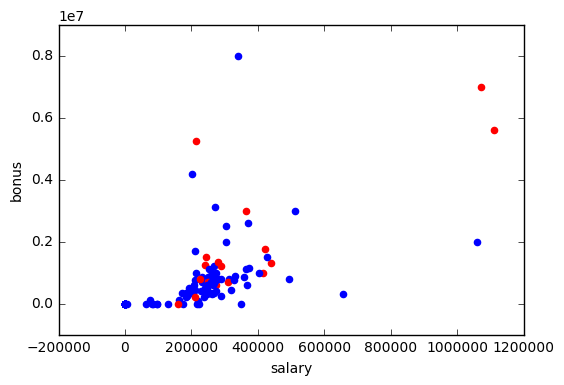

In [136]:
### Task 2: Remove outliers
data_dict.pop("TOTAL", 0)
data = featureFormat(my_dataset, features_list, sort_keys = True)
plotScatter(data, features_list)

## 2.1. Select Features


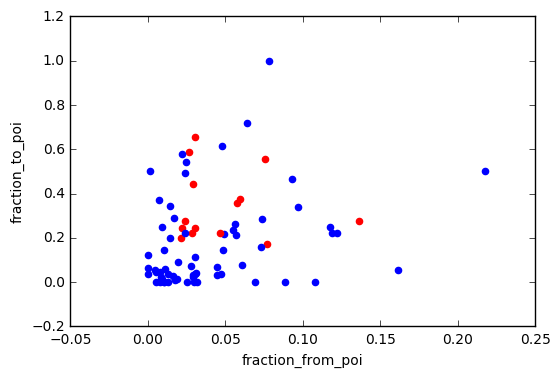

In [137]:
### Task 3: Create new feature(s)
def computeFraction(numerator, denominator):
    if (numerator != "NaN") | (denominator != "NaN"):
        return (float(numerator) / float(denominator))
    else:
        return 0.

def computeSummation(numerator, denominator):
    if (numerator != "NaN") | (denominator != "NaN"):
        return float(numerator) + float(denominator)
    else:
        return 0.

def addNewFeature(dat, name, numer, denom=None, compute=False):
    new = {}
    if compute == "fraction":
        for key, val in dat.items():
            fraction = computeFraction(val[numer], val[denom])
            val[name] = fraction
            new[key] = val
        features_list.append(name)
    elif compute == "sum":
        for key, val in dat.items():
            summation = computeSummation(val[numer], val[denom])
            val[name] = summation
            new[key] = val
        features_list.append(name)
    else:
        for key, val in dat.items():       
            val[name] = numer[key]
            new[key] = val
        features_list.append(name)
    return new

my_dataset = addNewFeature(my_dataset, 
                           "fraction_from_poi", 
                           "from_poi_to_this_person", "to_messages", compute = "fraction")

my_dataset = addNewFeature(my_dataset, 
                           "fraction_to_poi", 
                           "from_this_person_to_poi", "from_messages", compute = "fraction")

data = featureFormat(my_dataset, ["poi", "fraction_from_poi", "fraction_to_poi"], 
                     sort_keys = True)

plotScatter(data, ["poi", "fraction_from_poi", "fraction_to_poi"])

In [138]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    
from sklearn.feature_selection import SelectKBest, f_classif
clf = SelectKBest(f_classif, k = 8)
clf.fit_transform(features_train, labels_train)
features_train_tr = clf.transform(features_test)

def findScores(score, names):
    new = {}
    board = []
    player = []
    for i, value in enumerate(score):
        player.append(names[i+1])
        board.append(round(value, 2))
    new["feature"] = player
    new["score"] = board
    return pd.DataFrame(new)

feature_sc = findScores(clf.scores_, features_list)

feature_sc2 = feature_sc.sort_values(by=["score"], 
                                     ascending=False).set_index('feature', drop=True)
print feature_sc2

                           score
feature                         
bonus                      30.65
salary                     15.81
fraction_to_poi            13.79
total_stock_value          10.81
shared_receipt_with_poi    10.67
exercised_stock_options     9.96
total_payments              8.96
deferred_income             8.49
restricted_stock            8.05
long_term_incentive         7.53
loan_advances               7.04
from_poi_to_this_person     4.94
expenses                    4.31
other                       3.20
to_messages                 2.61
director_fees               1.64
restricted_stock_deferred   0.68
fraction_from_poi           0.49
from_messages               0.43
from_this_person_to_poi     0.11
deferral_payments           0.01


/Users/mjmarketing/anaconda/envs/DAND/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


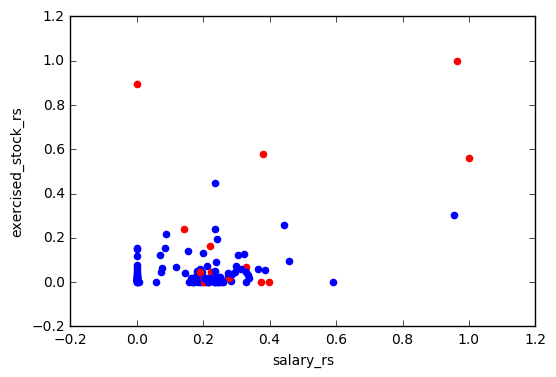

In [133]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def scaleVariable(dat, feature):
    new = {}
    bucket = []
    for key, val in dat.items():
        elem = []
        if val[feature] != "NaN":
            elem.append(float(val[feature]))
        else:
            elem.append(0.)
        bucket.append(elem)
        
    bucket_np = np.array(bucket)
    scaler = MinMaxScaler()
    rescaled_variable = scaler.fit_transform(bucket_np)
    
    i = 0
    for key, val in dat.items():
        new[key] = rescaled_variable[i]
        i += 1
    return new

salary_rs = scaleVariable(my_dataset, "salary")
bonus_rs = scaleVariable(my_dataset, "bonus")
exercised_stock_rs = scaleVariable(my_dataset, "exercised_stock_options")

my_dataset = addNewFeature(my_dataset, "salary_rs", salary_rs)
my_dataset = addNewFeature(my_dataset, "bonus_rs", bonus_rs)
my_dataset = addNewFeature(my_dataset, "exercised_stock_rs", exercised_stock_rs)

my_dataset = addNewFeature(my_dataset, 
                           "salary_stock", 
                           "salary_rs", "exercised_stock_rs", compute = "sum")

data = featureFormat(my_dataset, 
                     ["poi", "salary_rs", "exercised_stock_rs"], sort_keys = True)
plotScatter(data, ["poi", "salary_rs", "exercised_stock_rs"])

In [16]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
# from sklearn.naive_bayes import GaussianNB
# clf = GaussianNB()

labels, features = targetFeatureSplit(data)

0.818181818182
[10  6  1  2  4]


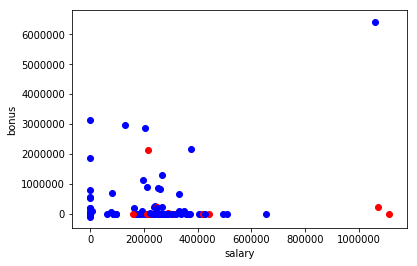

In [31]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    
from sklearn import tree
from sklearn.metrics import accuracy_score
clf = tree.DecisionTreeClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
important = clf.feature_importances_

print accuracy_score(labels_test, pred)

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

### Code Here